Statistical errors of ANN models

In [1]:
import numpy as np
import torch
if torch.cuda.device_count():
    device = 'cuda'
    print('Good to go')
else:
    device = 'cpu'
    print('Using cpu')

Good to go


In [2]:
#load saved model
from Neural_network import NN_net, Plain_fc_block, weight_init, eMNS_Dataset
num_input = 15
num_output = 3
fc_stages = [(num_input,100,1),(100,50,1),(50,25,1)]
fc_network = NN_net(None,fc_stages,None,Plain_fc_block, num_output=num_output)

fc_network = torch.load('EMS_ANN.pt', map_location="cuda:0")
fc_network.eval()
fc_network.to(device)

NN_net(
  (total_net): Sequential(
    (0): NN_stages(
      (net): Sequential(
        (0): Plain_fc_block(
          (fc): Linear(in_features=15, out_features=100, bias=True)
          (relu): ReLU()
        )
      )
    )
    (1): NN_stages(
      (net): Sequential(
        (0): Plain_fc_block(
          (fc): Linear(in_features=100, out_features=50, bias=True)
          (relu): ReLU()
        )
      )
    )
    (2): NN_stages(
      (net): Sequential(
        (0): Plain_fc_block(
          (fc): Linear(in_features=50, out_features=25, bias=True)
          (relu): ReLU()
        )
      )
    )
    (3): Linear(in_features=25, out_features=3, bias=True)
  )
)

In [26]:
from ReadData import ReadCurrentAndField 
import glob
import os 

# print(os.getcwd())
foldername="./Data/"
filepattern = "MagneticField[0-9]*.txt"
#data = ReadFolder(foldername,filepattern)
train_file_num = 50
data = ReadCurrentAndField (foldername,filepattern)

fileList = glob.glob(foldername+filepattern)

data=data.reshape(1460,21,21,21,18)
position = data[:,0:20:2,0:20:2,0:20:2,:15]
Bfield = data[:,0:20:2,0:20:2,0:20:2,15:]

#find min and max value of input position and Bfield
max_position, max_position_index = torch.max(position.reshape(-1,15), dim=0, keepdim=True)
print(max_position)
min_position, min_position_index = torch.min(position.reshape(-1,15), dim=0, keepdim=True)
print(min_position)

max_Bfield, max_Bfield_index = torch.max(Bfield.reshape(-1,3), dim=0, keepdim=True)
print(max_Bfield)
min_Bfield, min_Bfield_index = torch.min(Bfield.reshape(-1,3), dim=0, keepdim=True)
print(min_Bfield)

print(position.shape)
print(Bfield.shape)


dimp=position.shape
dimB=Bfield.shape

position_norm = (position-min_position.expand(dimp[0],dimp[1],dimp[2],dimp[3],dimp[4]))/(max_position.expand(dimp[0],dimp[1],dimp[2],dimp[3],dimp[4])-min_position.expand(dimp[0],dimp[1],dimp[2],dimp[3],dimp[4]))
Bfield_norm = (Bfield-min_Bfield.expand(dimB[0],dimB[1],dimB[2],dimB[3],dimB[4]))/(max_Bfield.expand(dimB[0],dimB[1],dimB[2],dimB[3],dimB[4])-min_Bfield.expand(dimB[0],dimB[1],dimB[2],dimB[3],dimB[4]))



tensor([[14.9943, 14.9997, 14.9988, 14.9575, 14.9915, 14.9808, 14.9884, 14.9878,
         14.9549, 14.9957, 14.9494, 14.9705,  0.0400,  0.0400,  0.0400]])
tensor([[-14.9800, -14.9944, -14.9962, -14.9903, -14.9597, -14.9911, -14.9693,
         -14.9875, -14.9992, -14.9837, -14.9949, -14.9139,  -0.0500,  -0.0500,
          -0.0500]])
tensor([[0.0525, 0.0638, 0.0608]])
tensor([[-0.0557, -0.0575, -0.0639]])
torch.Size([1460, 10, 10, 10, 15])
torch.Size([1460, 10, 10, 10, 3])


In [27]:
#calculate estimated Bfield value of ANN 

B_est_norm=torch.zeros(100,10,10,10,3)
for i in range (0,100):
    print(i)
    for j in range (0,position.shape[1]):
        for k in range(0,position.shape[2]):
            for l in range(0,position.shape[3]):
                input=position_norm[i,j,k,l,:].cuda(0)
                b = input.float().reshape(1,15)
                B_est_norm[i,j,k,l,:]=fc_network(b)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [28]:
print(B_est_norm.shape)
maxB=max_Bfield.expand(100,10,10,10,3)
minB=min_Bfield.expand(100,10,10,10,3)
print(Bfield.shape)

torch.Size([100, 10, 10, 10, 3])
torch.Size([1460, 10, 10, 10, 3])


In [32]:

B_est_norm=B_est_norm.cpu().detach().numpy()
Bfield_norm=Bfield_norm.detach().numpy()
maxB=maxB.detach().numpy()
minB=minB.detach().numpy()
B_est=B_est_norm*(maxB-minB)+minB
B_real=Bfield[0:100,:,:,:,:]
num_samples=B_est.shape[0]

print(B_est.shape)
print(B_real.shape)
import torch.nn.functional as F
mse = F.mse_loss(torch.tensor(B_est),torch.tensor(B_real),reduction='sum')
rmse = torch.sqrt(mse/num_samples/10*10*10)
print(rmse)


(100, 10, 10, 10, 3)
torch.Size([100, 10, 10, 10, 3])
tensor(1.0844)


C:\Users\14032\AppData\Local\Temp\ipykernel_39292\555286664.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mse = F.mse_loss(torch.tensor(B_est),torch.tensor(B_real),reduction='sum')


<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
C:\Users\14032\AppData\Local\Temp\ipykernel_39292\3784000866.py:10: SyntaxWarning: invalid escape sequence '\m'
  ylables=['Bx\mT','By\mT','Bz\mT']
C:\Users\14032\AppData\Local\Temp\ipykernel_39292\3784000866.py:10: SyntaxWarning: invalid escape sequence '\m'
  ylables=['Bx\mT','By\mT','Bz\mT']
C:\Users\14032\AppData\Local\Temp\ipykernel_39292\3784000866.py:10: SyntaxWarning: invalid escape sequence '\m'
  ylables=['Bx\mT','By\mT','Bz\mT']


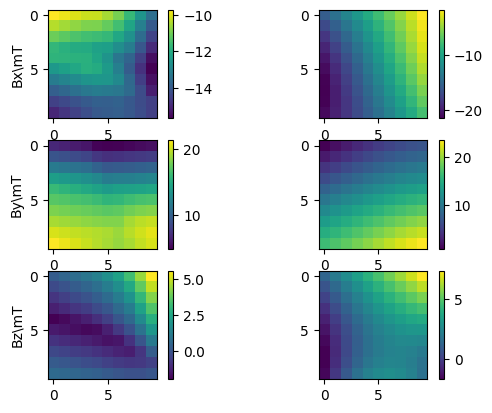

In [34]:
import matplotlib.pyplot as plt
import numpy as np
current_index=3
z_plane_index= 5
# fig, ax = plt.subplots(3, 2)
# fig.tight_layout(h_pad=2)
fig = plt.figure()
vmin=[0.5,  0.4,  0.6]
vmax=[0.65 , 0.55,  0.75]
ylables=['Bx\mT','By\mT','Bz\mT']
# fig.tight_layout(pad=0.4, w_pad=0, h_pad=0)
for i in range(1,4):
    plt.subplot(3,2,2*i-1)
    plt.imshow(B_est[current_index,:,:,z_plane_index,i-1]*1000)    #,vmin=vmin[i-1],vmax=vmax[i-1]
    plt.colorbar()
    plt.ylabel(ylables[i-1])
    plt.subplot(3,2,2*i)
    plt.imshow(B_real[current_index,:,:,z_plane_index,i-1]*1000)
    plt.colorbar()
plt.show()

In [ ]:
# from pylab import *
# subplots_adjust(left=0.0,bottom=0.0,top=1,right=1)
# fig, ax = plt.subplots(1, 3)
# fig.tight_layout()

# for i in range(1,4):
#     plt.subplot(1,3,i)
#     plt.imshow(Error_CNN[current_index,i-1,:,:,z_plane_index])    
#     plt.colorbar(fraction=0.04)    
# plt.show()